In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D, UpSampling1D, BatchNormalization, Dropout, GlobalMaxPooling1D, ConvLSTM1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

2024-05-17 05:05:33.704971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 05:05:34.318038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
timeframe = 40
stride = 1
num_features = 5

In [3]:
x_train = np.loadtxt('./data/X_train_transformed.csv')
x_train = x_train.reshape(x_train.shape[0], timeframe, num_features)
y_train = np.loadtxt('./data/y_train_transformed.csv').astype(int)
x_test = np.loadtxt('./data/X_test_transformed.csv')
x_test = x_test.reshape(x_test.shape[0], timeframe, num_features)
y_test = np.loadtxt('./data/y_test_transformed.csv').astype(int)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21560, 40, 5), (21560,), (5361, 40, 5), (5361,))

In [5]:
n_classes = 3

In [14]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

/home/bina/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [381]:
print(model.summary())

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 39, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 38, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 1216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │        77,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,027 (347.76 KB)

 Trainable params: 89,027 (347.76 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
unique_labels = np.unique(y_train)
class_mapping = {label: i for i, label in enumerate(unique_labels)}
y_train_encoded = np.array([class_mapping[label] for label in y_train])
y_test_encoded = np.array([class_mapping[label] for label in y_test])

In [17]:
history = model.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6909 - loss: 0.6604 - val_accuracy: 0.8677 - val_loss: 0.2782
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8920 - loss: 0.2363 - val_accuracy: 0.9017 - val_loss: 0.2057
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9092 - loss: 0.1928 - val_accuracy: 0.9220 - val_loss: 0.1679
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9231 - loss: 0.1683 - val_accuracy: 0.9064 - val_loss: 0.1877
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9253 - loss: 0.1681 - val_accuracy: 0.9299 - val_loss: 0.1519


In [18]:
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.8697 - loss: 0.2728
Loss: 0.2781979739665985
Accuracy: 0.8677485585212708


In [19]:
# selection of 1000 random samples from the test set
random.seed(42)  # Pour obtenir des résultats reproductibles
random_indices = random.sample(range(len(x_test)), 1000)
X_test_sample = x_test[random_indices]
y_test_sample = y_test_encoded[random_indices]

# evaluation of the model on the 1000 samples
y_pred_model = model.predict(X_test_sample)
# we take the class with the highest probability
y_pred_classes = np.argmax(y_pred_model, axis = 1)
accuracy_model = accuracy_score(y_test_sample, y_pred_classes)
precision_model = precision_score(y_test_sample, y_pred_classes, average='weighted')
recall_model = recall_score(y_test_sample, y_pred_classes, average='weighted')
f1_score_model = f1_score(y_test_sample, y_pred_classes, average='weighted')
conf_matrix_model = confusion_matrix(y_test_sample, y_pred_classes)
accuracy_model, precision_model, recall_model, f1_score_model, conf_matrix_model

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


(0.875,
 0.8830046651952482,
 0.875,
 0.8744986647276574,
 array([[ 39,   3,  28],
        [  0, 587,   0],
        [ 51,  43, 249]]))

In [20]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


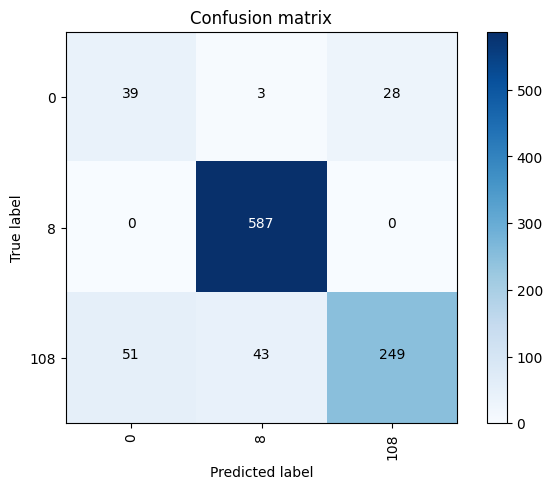

In [21]:
plot_confusion_matrix(conf_matrix_model, classes = [0, 8, 108])


In [22]:
model_2 = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),
    Conv1D(filters=128, kernel_size=2, activation='relu'),   
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
model_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_2.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/50


/home/bina/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7139 - loss: 0.6070 - val_accuracy: 0.8851 - val_loss: 0.2484
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8939 - loss: 0.2314 - val_accuracy: 0.8743 - val_loss: 0.2768
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9078 - loss: 0.2028 - val_accuracy: 0.9207 - val_loss: 0.1686
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9271 - loss: 0.1639 - val_accuracy: 0.9287 - val_loss: 0.1712
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9292 - loss: 0.1614 - val_accuracy: 0.9431 - val_loss: 0.1380


In [23]:
loss, accuracy = model_2.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8845 - loss: 0.2501
Loss: 0.2483772486448288
Accuracy: 0.8850960731506348


In [24]:
# selection of 1000 random samples from the test set
random.seed(42)  # Pour obtenir des résultats reproductibles
random_indices = random.sample(range(len(x_test)), 1000)
X_test_sample = x_test[random_indices]
y_test_sample = y_test_encoded[random_indices]

# evaluation of the model on the 1000 samples
y_pred_model_2 = model_2.predict(X_test_sample)
# we take the class with the highest probability
y_pred_classes = np.argmax(y_pred_model_2, axis = 1)
accuracy_model_2 = accuracy_score(y_test_sample, y_pred_classes)
precision_model_2 = precision_score(y_test_sample, y_pred_classes, average='weighted')
recall_model_2 = recall_score(y_test_sample, y_pred_classes, average='weighted')
f1_score_model_2 = f1_score(y_test_sample, y_pred_classes, average='weighted')
conf_matrix_model_2 = confusion_matrix(y_test_sample, y_pred_classes)
accuracy_model_2, precision_model_2, recall_model_2, f1_score_model_2, conf_matrix_model_2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(0.882,
 0.9143406914087311,
 0.882,
 0.8865547716923863,
 array([[ 63,   0,   7],
        [  0, 580,   7],
        [ 74,  30, 239]]))

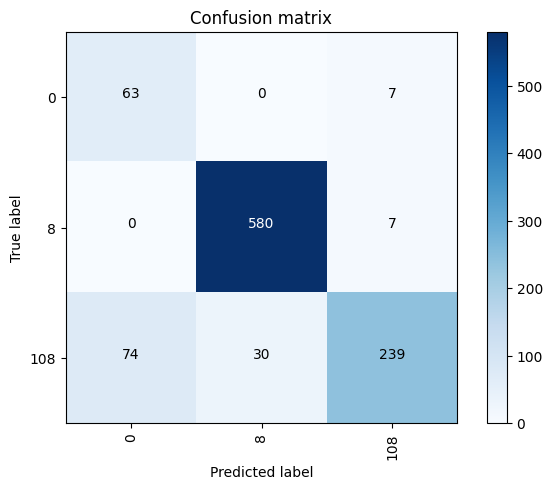

In [25]:
plot_confusion_matrix(conf_matrix_model_2, classes = [0, 8, 108])


In [82]:
model_3 = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
model_3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_3.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/50


/home/bina/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7804 - loss: 0.4654 - val_accuracy: 0.9123 - val_loss: 0.1583
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9195 - loss: 0.1614 - val_accuracy: 0.9368 - val_loss: 0.1281
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9339 - loss: 0.1407 - val_accuracy: 0.9463 - val_loss: 0.1218
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9453 - loss: 0.1236 - val_accuracy: 0.9455 - val_loss: 0.1191
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9481 - loss: 0.1207 - val_accuracy: 0.9541 - val_loss: 0.1057
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9585 - loss: 0.1017 - val_accuracy: 0.9569 - val_loss: 0.0980
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9620 - loss: 0.0937 - val_accuracy: 0.9623 - val_loss: 0.0907
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9683 - loss: 0.0835 - val_accuracy: 0.9612 - val_

In [83]:
loss, accuracy = model_3.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.9641 - loss: 0.0903
Loss: 0.08391840010881424
Accuracy: 0.9667972326278687


In [93]:
random_indices = random.sample(range(len(x_test)), 1000)
X_test_sample = x_test[random_indices]
y_test_sample = y_test_encoded[random_indices]

# evaluation of the model on the 1000 samples
y_pred_model_3 = model_3.predict(X_test_sample)
# we take the class with the highest probability
y_pred_classes = np.argmax(y_pred_model_3, axis = 1)
accuracy_model_3 = accuracy_score(y_test_sample, y_pred_classes)
precision_model_3 = precision_score(y_test_sample, y_pred_classes, average='weighted')
recall_model_3 = recall_score(y_test_sample, y_pred_classes, average='weighted')
f1_score_model_3 = f1_score(y_test_sample, y_pred_classes, average='weighted')
conf_matrix_model_3 = confusion_matrix(y_test_sample, y_pred_classes)
accuracy_model_3, precision_model_3, recall_model_3, f1_score_model_3, conf_matrix_model_3

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.96,
 0.9598278598768346,
 0.96,
 0.9598026328926874,
 array([[ 64,   0,   9],
        [  0, 573,   6],
        [  9,  16, 323]]))

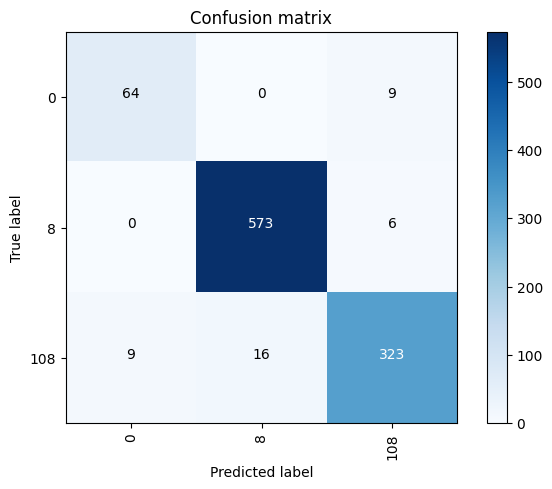

In [94]:
plot_confusion_matrix(conf_matrix_model_3, classes = [0, 8, 108])


In [9]:
model_4 = Sequential([
   Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),
   Conv1D(filters=64, kernel_size=2, activation='relu'),
   MaxPooling1D(pool_size=2),
   Conv1D(filters=16, kernel_size=2, activation='relu'),
   MaxPooling1D(pool_size=2),
   Flatten(),
   Dense(64, activation='relu'),
   Dense(n_classes, activation='softmax')
])
model_4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_4.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

/home/bina/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


2024-05-17 05:06:00.178271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 05:06:00.178781: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5926 - loss: 0.8595 - val_accuracy: 0.7872 - val_loss: 0.5047
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8214 - loss: 0.4414 - val_accuracy: 0.8672 - val_loss: 0.3274
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8773 - loss: 0.3028 - val_accuracy: 0.8845 - val_loss: 0.2679
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8903 - loss: 0.2609 - val_accuracy: 0.8948 - val_loss: 0.2491
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9045 - loss: 0.2280 - val_accuracy: 0.8918 - val_loss: 0.2344
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9093 - loss: 0.2166 - val_accuracy: 0.8457 - val_loss: 0.3601
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9051 - loss: 0.2228 - val_accuracy: 0.9071 - val_loss: 0.2069
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9158 - loss: 0.1915 - val_accuracy: 0.8814 - val_

In [10]:
loss, accuracy = model_4.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.9595 - loss: 0.1144
Loss: 0.10946529358625412
Accuracy: 0.9615743160247803


In [11]:
random_indices = random.sample(range(len(x_test)), 1000)
X_test_sample = x_test[random_indices]
y_test_sample = y_test_encoded[random_indices]

# evaluation of the model on the 1000 samples
y_pred_model_4 = model_4.predict(X_test_sample)
# we take the class with the highest probability
y_pred_classes = np.argmax(y_pred_model_4, axis = 1)
accuracy_model_4 = accuracy_score(y_test_sample, y_pred_classes)
precision_model_4 = precision_score(y_test_sample, y_pred_classes, average='weighted')
recall_model_4 = recall_score(y_test_sample, y_pred_classes, average='weighted')
f1_score_model_4 = f1_score(y_test_sample, y_pred_classes, average='weighted')
conf_matrix_model_4 = confusion_matrix(y_test_sample, y_pred_classes)
accuracy_model_4, precision_model_4, recall_model_4, f1_score_model_4, conf_matrix_model_4

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.96,
 0.9623235352787242,
 0.96,
 0.9602762669664037,
 array([[ 69,   0,   3],
        [  0, 586,   6],
        [ 17,  14, 305]]))